# 🎲 Monte Carlo Lineup Simulations

## Overview
Simulates 50,000 fantasy football outcomes using lognormal distributions based on player projections.

## Methodology
- **Distribution**: Lognormal
- **Simulations**: N = 10,000
- **Seed**: 1738 (for reproducibility)

## Lognormal Parameterization
Given player mean (μ) and standard deviation (σ):

$$\phi = \sqrt{\sigma^2 + \mu^2}$$

$$\sigma_{ln} = \sqrt{\log\left(\frac{\phi}{\mu}\right)^2}$$

$$\mu_{ln} = \log\left(\frac{\mu^2}{\phi}\right)$$

For degenerate cases (σ = 0), we set $\sigma_{ln} = 10^{-9}$


## 📦 Setup & Configuration


In [1]:
import numpy as np
import sqlite3
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import json
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

# Set style for elegant plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

# Simulation parameters
SEED = 1738
N_SIMULATIONS = 50000
CURRENT_WEEK = 10

np.random.seed(SEED)

print("✓ Libraries loaded")
print(f"✓ Random seed: {SEED}")
print(f"✓ Simulations: {N_SIMULATIONS:,}")
print(f"✓ Week: {CURRENT_WEEK}")

# Get absolute paths to databases
NOTEBOOK_DIR = Path().absolute()
BACKEND_DIR = NOTEBOOK_DIR.parent
DB_PROJ_PATH = str(BACKEND_DIR / "data" / "databases" / "projections.db")
DB_LEAGUE_PATH = str(BACKEND_DIR / "data" / "databases" / "league.db")
DB_MONTECARLO_PATH = str(BACKEND_DIR / "data" / "databases" / "montecarlo.db")
DB_ODDS_PATH = str(BACKEND_DIR / "data" / "databases" / "odds.db")


✓ Libraries loaded
✓ Random seed: 1738
✓ Simulations: 50,000
✓ Week: 10


## 📊 Load Lineup Data


In [2]:
# Load team lineups from optimizer output
df_lineups = pd.read_csv(f'../data/csv/team_lineups_week_{CURRENT_WEEK}.csv')

print(f"✓ Loaded {len(df_lineups)} lineup slots")
print(f"  Teams: {df_lineups['roster_id'].nunique()}")
print(f"  Total starters: {len(df_lineups)}")

# Show sample
print("\nSample lineup data:")
print(df_lineups.head(10)[['roster_id', 'team_name', 'slot', 'player_name', 'mu', 'sigma']].to_string(index=False))


✓ Loaded 108 lineup slots
  Teams: 12
  Total starters: 108

Sample lineup data:
 roster_id team_name slot            player_name        mu     sigma
         1    Team 1   QB          Waiver Pickup 15.905000 12.997143
         1    Team 1    K           Cairo Santos  8.466667  4.026578
         1    Team 1  DEF             NE Defense  5.900000  7.906959
         1    Team 1   RB         Bijan Robinson 20.692000  9.152556
         1    Team 1   RB Jacory Croskey-Merritt  9.740000  9.228868
         1    Team 1   WR           Emeka Egbuka 15.646000 10.066098
         1    Team 1   WR       Jameson Williams 11.304000 10.117328
         1    Team 1   TE           Trey McBride 15.552000  8.325508
         1    Team 1 FLEX             Tre Tucker 10.412000 10.081611
         2    Team 2   QB         Caleb Williams 18.724000  7.113896


## 🎲 Lognormal Parameterization Functions


In [3]:
def lognormal_params(mu: float, sigma: float) -> Tuple[float, float]:
    """
    Convert mean and std to lognormal parameters.
    
    Args:
        mu: Mean of the distribution
        sigma: Standard deviation of the distribution
        
    Returns:
        (mu_ln, sigma_ln): Lognormal distribution parameters
    """
    # Handle degenerate case (zero variance)
    if sigma == 0 or sigma < 1e-10:
        sigma_ln = 1e-9
        mu_ln = np.log(mu) if mu > 0 else 0
        return mu_ln, sigma_ln
    
    # Handle near-zero or negative mu
    if mu <= 0:
        mu = 1e-6
    
    # Calculate phi
    phi = np.sqrt(sigma**2 + mu**2)
    
    # Calculate lognormal parameters
    sigma_ln = np.sqrt(np.log((phi / mu)**2))
    mu_ln = np.log(mu**2 / phi)
    
    return mu_ln, sigma_ln


def simulate_player(mu: float, sigma: float, n_sims: int = N_SIMULATIONS) -> np.ndarray:
    """
    Simulate player points using lognormal distribution.
    
    Args:
        mu: Mean projected points
        sigma: Standard deviation of projected points
        n_sims: Number of simulations
        
    Returns:
        Array of simulated points (shape: n_sims)
    """
    mu_ln, sigma_ln = lognormal_params(mu, sigma)
    return np.random.lognormal(mu_ln, sigma_ln, size=n_sims)


print("✓ Lognormal parameterization functions defined")

# Test the functions
print("\nTest cases:")
test_cases = [
    (20.0, 5.0, "Normal case"),
    (15.0, 0.0, "Zero variance"),
    (10.0, 10.0, "High variance"),
    (0.0, 0.0, "Zero mean and variance")
]

for mu, sigma, desc in test_cases:
    mu_ln, sigma_ln = lognormal_params(mu, sigma)
    print(f"  {desc}: μ={mu:.1f}, σ={sigma:.1f} → μ_ln={mu_ln:.4f}, σ_ln={sigma_ln:.4f}")


✓ Lognormal parameterization functions defined

Test cases:
  Normal case: μ=20.0, σ=5.0 → μ_ln=2.9654, σ_ln=0.2462
  Zero variance: μ=15.0, σ=0.0 → μ_ln=2.7081, σ_ln=0.0000
  High variance: μ=10.0, σ=10.0 → μ_ln=1.9560, σ_ln=0.8326
  Zero mean and variance: μ=0.0, σ=0.0 → μ_ln=0.0000, σ_ln=0.0000


## 🎯 Run Monte Carlo Simulations


In [4]:
print("Running Monte Carlo simulations...\n")

# Reset seed for reproducibility
np.random.seed(SEED)

# Store all simulation results
all_simulations = []

# Get unique teams
teams = df_lineups['roster_id'].unique()

for team_id in teams:
    # Get this team's lineup
    team_lineup = df_lineups[df_lineups['roster_id'] == team_id].copy()
    team_name = team_lineup.iloc[0]['team_name']
    owner = team_lineup.iloc[0]['owner']
    
    n_players = len(team_lineup)
    
    print(f"Team {team_id}: {team_name} ({owner})")
    print(f"  Players in lineup: {n_players}")
    
    # Simulate each player
    player_simulations = []
    
    for idx, player in team_lineup.iterrows():
        mu = player['mu']
        sigma = player['sigma']
        
        # Simulate this player N_SIMULATIONS times
        player_sims = simulate_player(mu, sigma, N_SIMULATIONS)
        player_simulations.append(player_sims)
    
    # Stack into array (shape: n_sims x n_players)
    team_draws = np.column_stack(player_simulations)
    
    # Sum across players to get team totals (shape: n_sims)
    team_totals = team_draws.sum(axis=1)
    
    print(f"  Mean simulated total: {team_totals.mean():.2f}")
    print(f"  Median simulated total: {np.median(team_totals):.2f}")
    print(f"  Std simulated total: {team_totals.std():.2f}")
    print(f"  Min: {team_totals.min():.2f}, Max: {team_totals.max():.2f}")
    print()
    
    # Store results in long format
    for sim_id, total_points in enumerate(team_totals):
        all_simulations.append({
            'week': CURRENT_WEEK,
            'sim_id': sim_id,
            'team_id': team_id,
            'team_name': team_name,
            'owner': owner,
            'total_points': total_points
        })

# Create DataFrame
df_simulations = pd.DataFrame(all_simulations)

print(f"✓ Completed {N_SIMULATIONS:,} simulations for {len(teams)} teams")
print(f"✓ Total simulation records: {len(df_simulations):,}")


Running Monte Carlo simulations...

Team 1: Team 1 (xavierking4)
  Players in lineup: 9
  Mean simulated total: 113.63
  Median simulated total: 109.76
  Std simulated total: 28.34
  Min: 44.60, Max: 513.95

Team 2: Team 2 (asadrafique)
  Players in lineup: 9
  Mean simulated total: 109.43
  Median simulated total: 105.73
  Std simulated total: 26.61
  Min: 44.92, Max: 395.00

Team 3: Team 3 (amir812)
  Players in lineup: 9
  Mean simulated total: 125.28
  Median simulated total: 121.73
  Std simulated total: 28.14
  Min: 53.92, Max: 718.81

Team 4: Team 4 (umarrahman30)
  Players in lineup: 9
  Mean simulated total: 110.92
  Median simulated total: 107.20
  Std simulated total: 27.30
  Min: 40.68, Max: 491.38

Team 5: Team 5 (TBK41)
  Players in lineup: 9
  Mean simulated total: 113.80
  Median simulated total: 110.24
  Std simulated total: 26.48
  Min: 46.35, Max: 386.94

Team 6: Team 6 (Jibraan)
  Players in lineup: 9
  Mean simulated total: 125.64
  Median simulated total: 122.61
 

## 💾 Save Simulation Results


In [5]:
# Save to CSV
output_file = f'../data/csv/monte_carlo_simulations_week_{CURRENT_WEEK}.csv'
df_simulations.to_csv(output_file, index=False)

print(f"✓ Saved simulation results to CSV: {output_file}")
print(f"  File size: {len(df_simulations):,} rows")

# Save to Database
conn_mc = sqlite3.connect(DB_MONTECARLO_PATH)
cursor = conn_mc.cursor()

# Create table for simulations
cursor.execute("""
    CREATE TABLE IF NOT EXISTS monte_carlo_simulations (
        run_id TEXT NOT NULL,
        week INTEGER NOT NULL,
        sim_id INTEGER NOT NULL,
        team_id INTEGER NOT NULL,
        team_name TEXT,
        owner TEXT,
        total_points REAL NOT NULL,
        created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
        PRIMARY KEY (run_id, week, sim_id, team_id)
    )
""")

# Create a run_id based on seed and timestamp
from datetime import datetime
run_id = f"seed_{SEED}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

# Add run_id to dataframe
df_simulations['run_id'] = run_id

# Insert simulations
df_simulations.to_sql('monte_carlo_simulations', conn_mc, if_exists='append', index=False)

conn_mc.commit()
conn_mc.close()

print(f"✓ Saved simulation results to database: montecarlo.db")
print(f"  Run ID: {run_id}")
print(f"  Table: monte_carlo_simulations")


✓ Saved simulation results to CSV: ../data/csv/monte_carlo_simulations_week_10.csv
  File size: 600,000 rows
✓ Saved simulation results to database: montecarlo.db
  Run ID: seed_1738_20251106_212816
  Table: monte_carlo_simulations


### Save Simulation Run Metadata


In [6]:
# Save metadata about this simulation run
conn_mc = sqlite3.connect(DB_MONTECARLO_PATH)
cursor = conn_mc.cursor()

# Create metadata table
cursor.execute("""
    CREATE TABLE IF NOT EXISTS simulation_runs (
        run_id TEXT PRIMARY KEY,
        week INTEGER NOT NULL,
        seed INTEGER NOT NULL,
        n_simulations INTEGER NOT NULL,
        distribution_type TEXT,
        n_teams INTEGER,
        n_matchups INTEGER,
        created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
    )
""")

# Insert this run's metadata
cursor.execute("""
    INSERT OR REPLACE INTO simulation_runs 
    (run_id, week, seed, n_simulations, distribution_type, n_teams, n_matchups)
    VALUES (?, ?, ?, ?, ?, ?, ?)
""", (
    run_id,
    CURRENT_WEEK,
    SEED,
    N_SIMULATIONS,
    'lognormal',
    len(teams),
    len(matchups) if 'matchups' in locals() else 0
))

conn_mc.commit()
conn_mc.close()

print("✓ Saved simulation run metadata to montecarlo.db")
print(f"  Table: simulation_runs")


✓ Saved simulation run metadata to montecarlo.db
  Table: simulation_runs


## 📊 Simulation Summary Statistics


In [7]:
# Calculate summary statistics per team
summary_stats = df_simulations.groupby(['team_id', 'team_name', 'owner'])['total_points'].agg([
    ('mean', 'mean'),
    ('median', 'median'),
    ('std', 'std'),
    ('min', 'min'),
    ('max', 'max'),
    ('p10', lambda x: np.percentile(x, 10)),
    ('p25', lambda x: np.percentile(x, 25)),
    ('p75', lambda x: np.percentile(x, 75)),
    ('p90', lambda x: np.percentile(x, 90))
]).reset_index()

# Round for display
summary_stats = summary_stats.round(2)

# Sort by mean
summary_stats = summary_stats.sort_values('mean', ascending=False)

print("="*120)
print("MONTE CARLO SIMULATION SUMMARY")
print(f"Week {CURRENT_WEEK} | {N_SIMULATIONS:,} Simulations per Team | Seed: {SEED}")
print("="*120)
print()

display_cols = ['team_id', 'team_name', 'owner', 'mean', 'median', 'std', 'p10', 'p25', 'p75', 'p90']
print(summary_stats[display_cols].to_string(index=False))

print()
print("="*120)


MONTE CARLO SIMULATION SUMMARY
Week 10 | 50,000 Simulations per Team | Seed: 1738

 team_id team_name              owner   mean  median   std   p10    p25    p75    p90
       6    Team 6            Jibraan 125.64  122.61 26.22 95.19 107.22 140.60 159.79
       3    Team 3            amir812 125.28  121.73 28.14 93.28 105.68 140.70 161.44
       7    Team 7        mehdidrissi 119.13  115.81 26.24 88.95 100.84 133.79 152.74
      10   Team 10 monkeyman966699696 118.40  115.06 26.32 88.05  99.79 133.26 152.69
      11   Team 11             Ammady 116.75  113.35 26.34 86.47  98.12 131.55 150.98
       5    Team 5              TBK41 113.80  110.24 26.48 83.95  95.23 128.43 147.87
       1    Team 1        xavierking4 113.63  109.76 28.34 81.86  93.84 128.92 149.81
       4    Team 4       umarrahman30 110.92  107.20 27.30 80.34  91.93 125.44 145.83
      12   Team 12           sfaizi24 110.87  107.12 26.63 81.46  92.64 124.59 144.22
       9    Team 9           Bilal879 110.51  106.61 28.1

## 📈 Visualization 1: Distribution of Team Outcomes


Creating individual team distribution plots...
Saved 12 individual distribution plots

Creating overlay distribution plot...


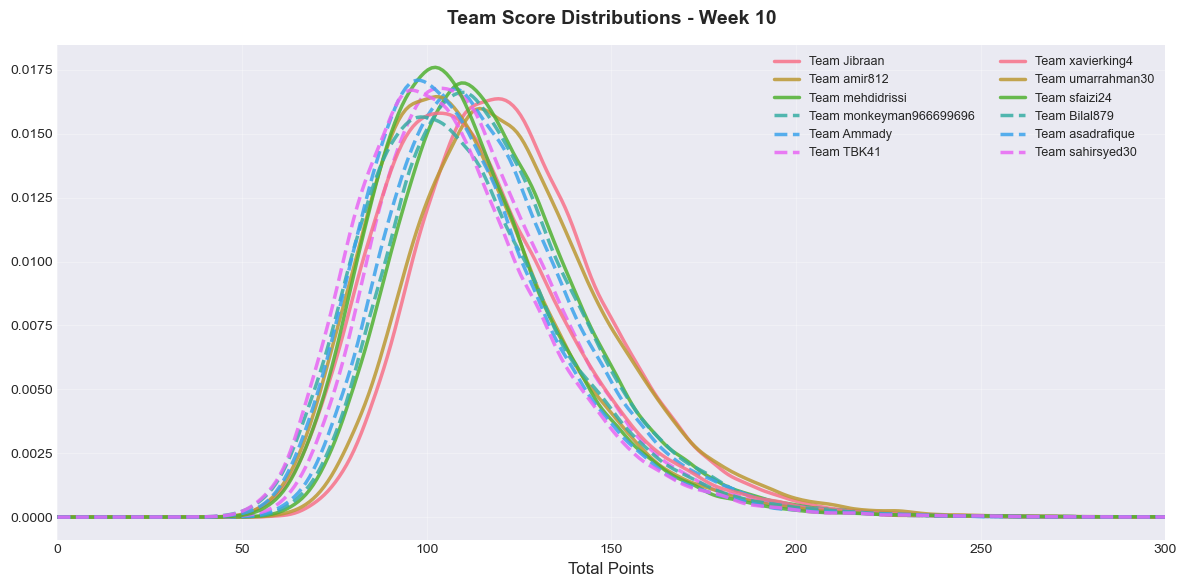

✓ Saved: simulation_distributions_overlay_week_10.png


In [8]:
# Create individual distribution plots for each team
print("Creating individual team distribution plots...")

# Sort teams by mean for consistent ordering
team_order = summary_stats.sort_values('mean', ascending=False)['team_id'].values

for idx, team_id in enumerate(team_order):
    team_data = summary_stats[summary_stats['team_id'] == team_id].iloc[0]
    team_display = f"Team {team_data['owner']}"
    owner = team_data['owner']
    points = df_simulations[df_simulations['team_id'] == team_id]['total_points'].values
    
    # Create individual figure
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Plot histogram
    ax.hist(points, bins=50, alpha=0.7, color=f'C{idx}', edgecolor='black', linewidth=0.5)
    
    # Add vertical lines for mean and median
    mean_val = team_data['mean']
    median_val = team_data['median']
    p10_val = team_data['p10']
    p90_val = team_data['p90']
    
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.1f}')
    ax.axvline(median_val, color='blue', linestyle=':', linewidth=2, label=f'Median: {median_val:.1f}')
    
    # Add shaded region for 10-90th percentile
    ax.axvspan(p10_val, p90_val, alpha=0.2, color='gray', label=f'10-90%: {p10_val:.1f}-{p90_val:.1f}')
    
    # Title with just team name (no numbers)
    ax.set_title(f'{team_display}', fontsize=14, fontweight='bold', pad=10)
    
    # Set x-axis limits and remove y-axis labels
    ax.set_xlim(0, 350)
    ax.set_xlabel('Total Points', fontsize=10)
    ax.set_yticks([])
    ax.set_ylabel('')
    
    # Legend
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(axis='x', alpha=0.3)
    
    # Minimize whitespace
    plt.tight_layout(pad=0.5)
    
    # Save individual plot
    filename = f'../data/images/dist_{team_display.replace(" ", "_")}_week_{CURRENT_WEEK}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()

print(f"Saved {len(team_order)} individual distribution plots")

# Create overlay plot with all teams
print("\nCreating overlay distribution plot...")
fig, ax = plt.subplots(figsize=(12, 6))

# Define 6 colors and alternate between solid and dashed lines
colors = sns.color_palette('husl', 6)
line_styles = ['-', '-', '-', '--', '--', '--']  # First 3 solid, next 3 dashed

for idx, team_id in enumerate(team_order):
    team_data = summary_stats[summary_stats['team_id'] == team_id].iloc[0]
    team_display = f"Team {team_data['owner']}"
    points = df_simulations[df_simulations['team_id'] == team_id]['total_points'].values
    
    # Calculate KDE for smooth lines
    from scipy.stats import gaussian_kde
    kde = gaussian_kde(points)
    x_range = np.linspace(0, 300, 300)
    density = kde(x_range)
    
    # Use modulo to cycle through colors and line styles
    color_idx = idx % 6
    
    # Plot as line with proper team name
    ax.plot(x_range, density, label=team_display, linewidth=2.5, alpha=0.85,
            color=colors[color_idx], linestyle=line_styles[color_idx])

ax.set_title(f'Team Score Distributions - Week {CURRENT_WEEK}', fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Total Points', fontsize=12)
ax.set_ylabel('')  # Remove Density label
ax.set_xlim(0, 300)
ax.legend(loc='upper right', fontsize=9, ncol=2)
ax.grid(alpha=0.3)
plt.tight_layout()

plt.savefig(f'../data/images/simulation_distributions_overlay_week_{CURRENT_WEEK}.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: simulation_distributions_overlay_week_{CURRENT_WEEK}.png")


## 📊 Visualization 2: Box Plot Comparison


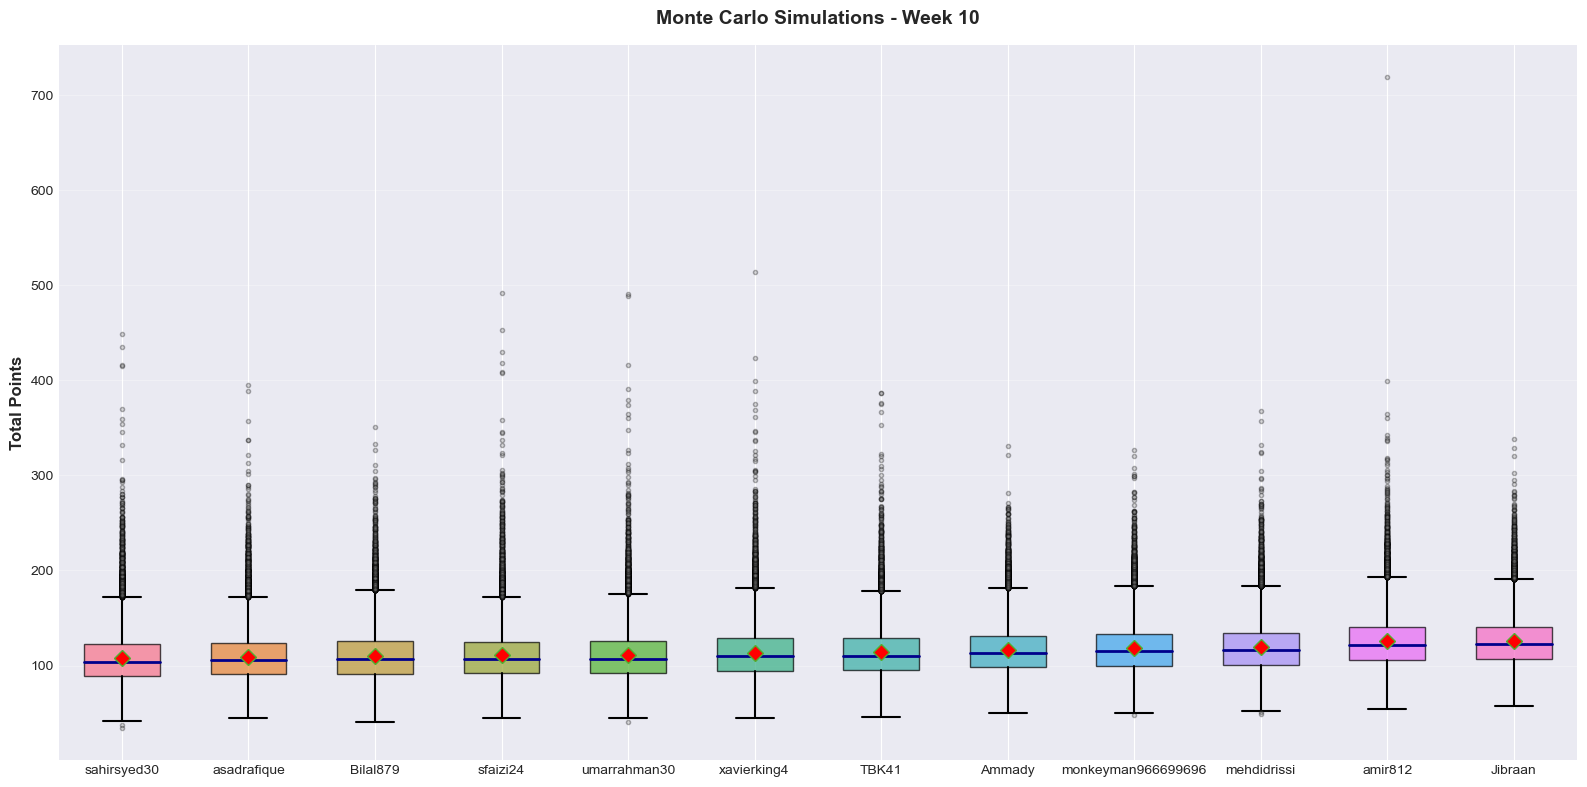

✓ Saved: simulation_boxplot_week_10.png


In [9]:
# Create box plot
fig, ax = plt.subplots(figsize=(16, 8))

# Prepare data sorted by median
sorted_teams = summary_stats.sort_values('median', ascending=True)
team_labels = [f"{row['owner']}" for _, row in sorted_teams.iterrows()]

# Get data in order
data_to_plot = [df_simulations[df_simulations['team_id'] == tid]['total_points'].values 
                for tid in sorted_teams['team_id']]

# Create box plot
bp = ax.boxplot(data_to_plot, 
                labels=team_labels,
                patch_artist=True,
                showmeans=True,
                meanprops=dict(marker='D', markerfacecolor='red', markersize=8),
                medianprops=dict(color='darkblue', linewidth=2),
                whiskerprops=dict(linewidth=1.5),
                capprops=dict(linewidth=1.5),
                flierprops=dict(marker='o', markerfacecolor='gray', markersize=3, alpha=0.3),
                widths=0.6)

# Color boxes
colors = sns.color_palette('husl', len(team_labels))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_xlabel('', fontsize=12)
ax.set_ylabel('Total Points', fontsize=12, fontweight='bold')
ax.set_title(f'Monte Carlo Simulations - Week {CURRENT_WEEK}', fontsize=14, fontweight='bold', pad=15)
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(f'../data/images/simulation_boxplot_week_{CURRENT_WEEK}.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: simulation_boxplot_week_{CURRENT_WEEK}.png")


## 📊 Visualization 3: Violin Plot with Percentiles


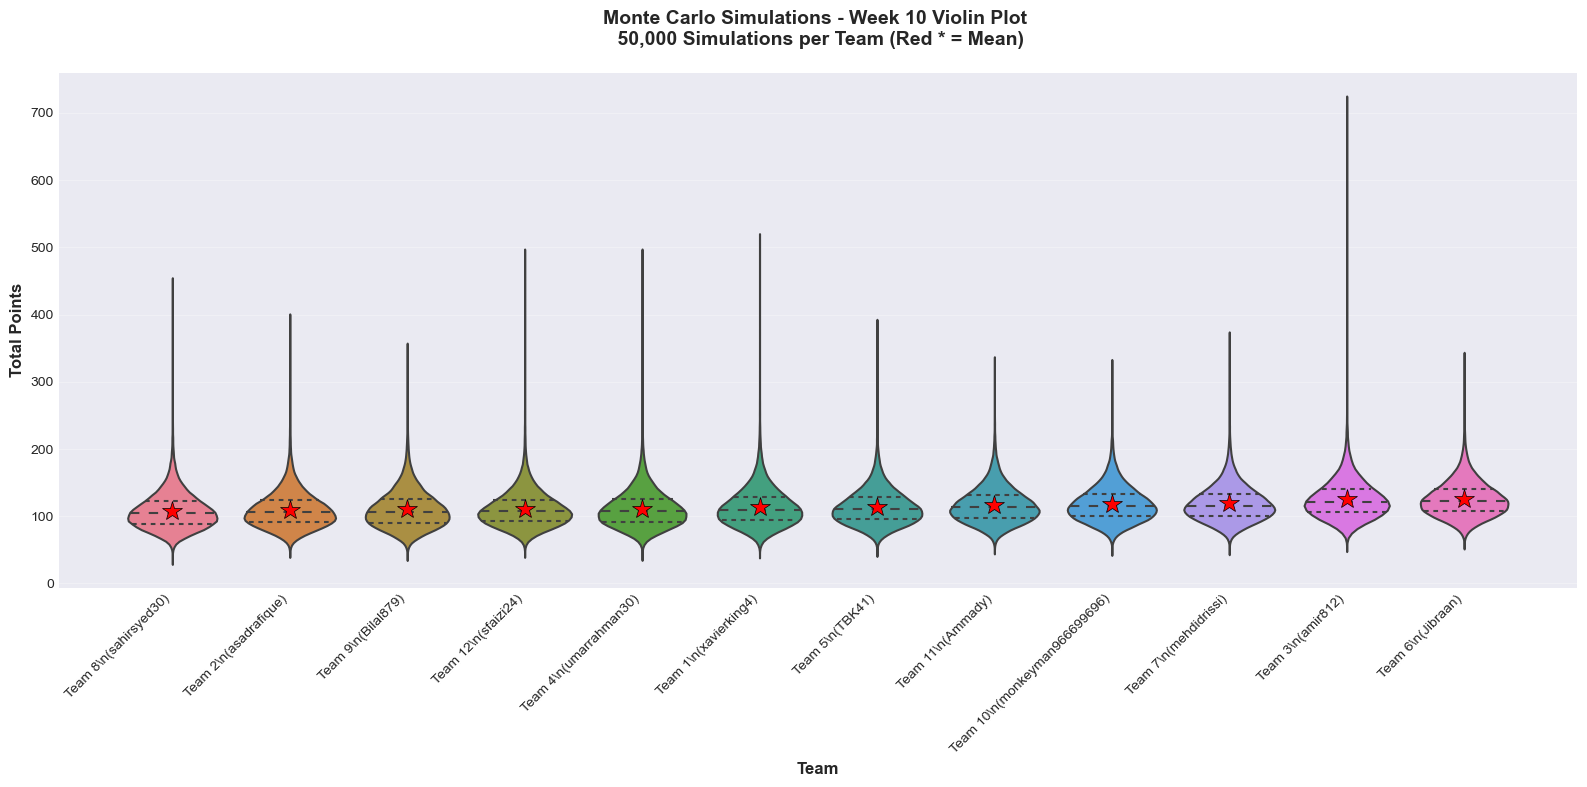

✓ Saved: simulation_violin_week_10.png


In [10]:
# Create violin plot
fig, ax = plt.subplots(figsize=(16, 8))

# Prepare data
plot_df = df_simulations.merge(summary_stats[['team_id', 'median']], on='team_id')
plot_df = plot_df.sort_values('median')
plot_df['team_label'] = plot_df['team_name'] + '\\n(' + plot_df['owner'] + ')'

# Create violin plot
sns.violinplot(data=plot_df, x='team_label', y='total_points', 
               palette='husl', inner='quartile', ax=ax)

# Add mean points
for i, (team_label, group) in enumerate(plot_df.groupby('team_label', sort=False)):
    mean_val = group['total_points'].mean()
    ax.plot(i, mean_val, 'r*', markersize=15, markeredgecolor='black', markeredgewidth=0.5)

ax.set_xlabel('Team', fontsize=12, fontweight='bold')
ax.set_ylabel('Total Points', fontsize=12, fontweight='bold')
ax.set_title(f'Monte Carlo Simulations - Week {CURRENT_WEEK} Violin Plot \n {N_SIMULATIONS:,} Simulations per Team (Red * = Mean)', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(f'../data/images/simulation_violin_week_{CURRENT_WEEK}.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: simulation_violin_week_{CURRENT_WEEK}.png")


## 📊 Visualization 4: Win Probability Heatmap


Calculating head-to-head win probabilities...



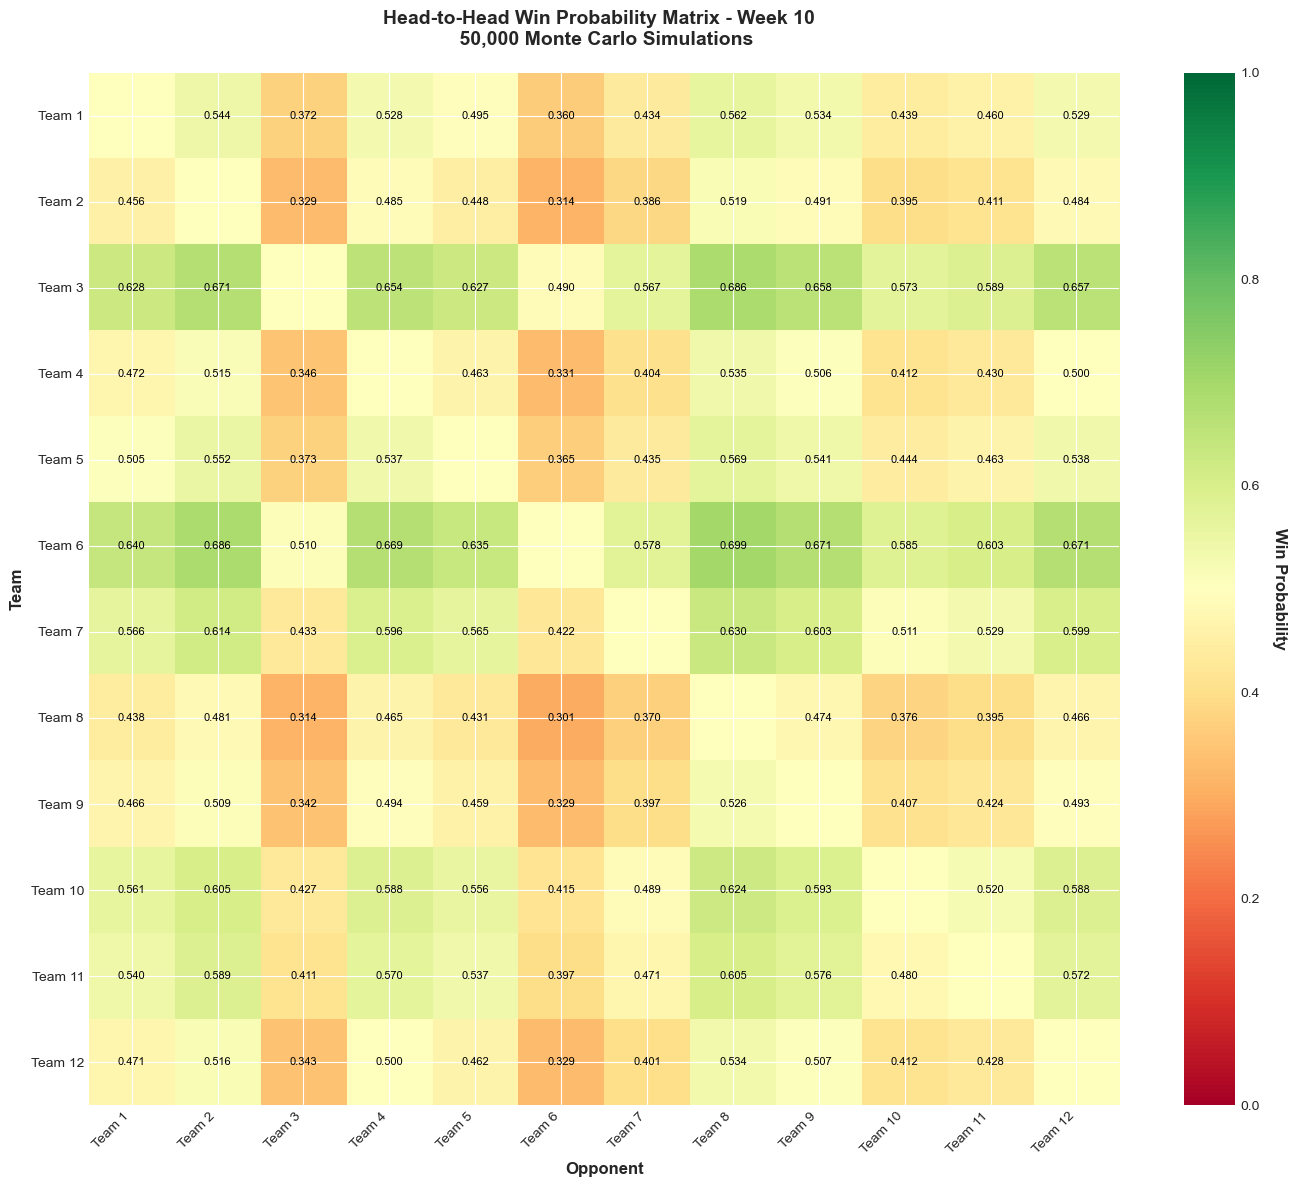

✓ Saved: win_probability_heatmap_week_10.png


In [11]:
# Calculate head-to-head win probabilities
print("Calculating head-to-head win probabilities...\n")

teams_list = sorted(df_simulations['team_id'].unique())
n_teams_list = len(teams_list)

# Create win probability matrix
win_prob_matrix = np.zeros((n_teams_list, n_teams_list))

for i, team_a in enumerate(teams_list):
    points_a = df_simulations[df_simulations['team_id'] == team_a]['total_points'].values
    
    for j, team_b in enumerate(teams_list):
        if i == j:
            win_prob_matrix[i, j] = 0.5  # Tie probability
        else:
            points_b = df_simulations[df_simulations['team_id'] == team_b]['total_points'].values
            wins = np.sum(points_a > points_b)
            win_prob_matrix[i, j] = wins / N_SIMULATIONS

# Create heatmap
fig, ax = plt.subplots(figsize=(14, 12))

# Get team names for labels
team_names = [df_simulations[df_simulations['team_id'] == tid]['team_name'].iloc[0] for tid in teams_list]

# Plot heatmap
im = ax.imshow(win_prob_matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Win Probability', rotation=270, labelpad=20, fontsize=12, fontweight='bold')

# Set ticks and labels
ax.set_xticks(np.arange(n_teams_list))
ax.set_yticks(np.arange(n_teams_list))
ax.set_xticklabels(team_names, rotation=45, ha='right')
ax.set_yticklabels(team_names)

# Add text annotations
for i in range(n_teams_list):
    for j in range(n_teams_list):
        if i != j:
            text = ax.text(j, i, f'{win_prob_matrix[i, j]:.3f}',
                          ha="center", va="center", color="black", fontsize=8)

ax.set_xlabel('Opponent', fontsize=12, fontweight='bold')
ax.set_ylabel('Team', fontsize=12, fontweight='bold')
ax.set_title(f'Head-to-Head Win Probability Matrix - Week {CURRENT_WEEK}  \n {N_SIMULATIONS:,} Monte Carlo Simulations', 
             fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig(f'../data/images/win_probability_heatmap_week_{CURRENT_WEEK}.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: win_probability_heatmap_week_{CURRENT_WEEK}.png")


## 📊 Visualization 5: Percentile Ranges Comparison


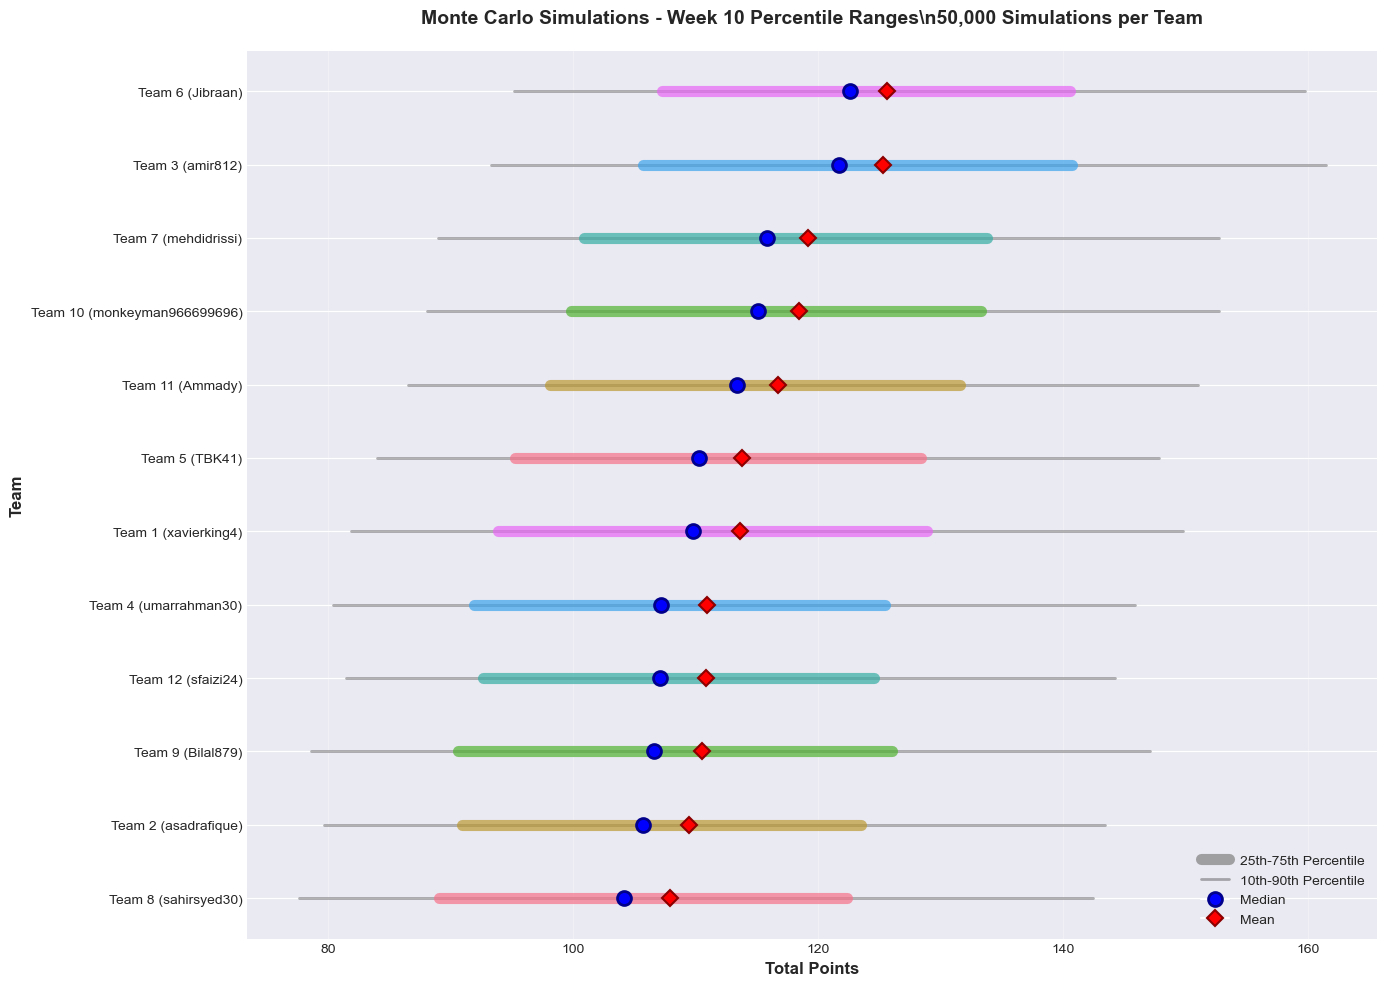

✓ Saved: percentile_ranges_week_10.png


In [12]:
# Create percentile range plot
fig, ax = plt.subplots(figsize=(14, 10))

# Sort teams by median
sorted_teams = summary_stats.sort_values('median', ascending=True)

y_positions = np.arange(len(sorted_teams))

for idx, (_, row) in enumerate(sorted_teams.iterrows()):
    team_id = row['team_id']
    team_name = row['team_name']
    owner = row['owner']
    
    # Get percentiles
    p10 = row['p10']
    p25 = row['p25']
    median = row['median']
    p75 = row['p75']
    p90 = row['p90']
    mean = row['mean']
    
    # Plot ranges
    # 10-90 percentile (thin line)
    ax.plot([p10, p90], [idx, idx], 'k-', linewidth=2, alpha=0.3)
    
    # 25-75 percentile (thick line)
    ax.plot([p25, p75], [idx, idx], color=f'C{idx}', linewidth=8, alpha=0.7)
    
    # Median (circle)
    ax.plot(median, idx, 'o', color='blue', markersize=10, markeredgecolor='darkblue', markeredgewidth=2)
    
    # Mean (diamond)
    ax.plot(mean, idx, 'D', color='red', markersize=8, markeredgecolor='darkred', markeredgewidth=1.5)

# Set labels
team_labels = [f"{row['team_name']} ({row['owner']})" for _, row in sorted_teams.iterrows()]
ax.set_yticks(y_positions)
ax.set_yticklabels(team_labels)
ax.set_xlabel('Total Points', fontsize=12, fontweight='bold')
ax.set_ylabel('Team', fontsize=12, fontweight='bold')
ax.set_title(f'Monte Carlo Simulations - Week {CURRENT_WEEK} Percentile Ranges\\n{N_SIMULATIONS:,} Simulations per Team', 
             fontsize=14, fontweight='bold', pad=20)

# Add legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='gray', linewidth=8, alpha=0.7, label='25th-75th Percentile'),
    Line2D([0], [0], color='black', linewidth=2, alpha=0.3, label='10th-90th Percentile'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, 
           markeredgecolor='darkblue', markeredgewidth=2, label='Median'),
    Line2D([0], [0], marker='D', color='w', markerfacecolor='red', markersize=8, 
           markeredgecolor='darkred', markeredgewidth=1.5, label='Mean')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(f'../data/images/percentile_ranges_week_{CURRENT_WEEK}.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: percentile_ranges_week_{CURRENT_WEEK}.png")


## 📊 Visualization 6: Cumulative Distribution Functions


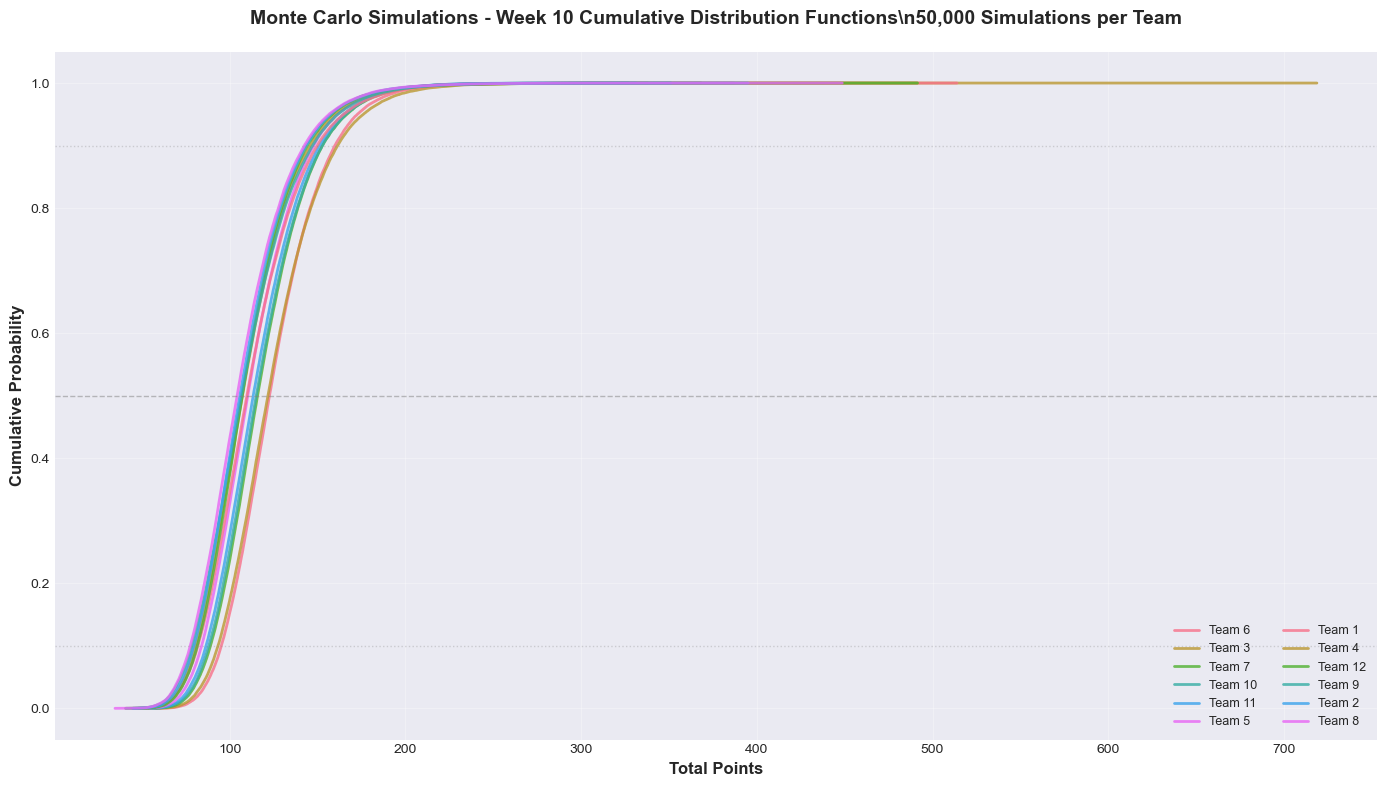

✓ Saved: cdf_plot_week_10.png


In [13]:
# Create CDF plot for all teams
fig, ax = plt.subplots(figsize=(14, 8))

# Sort teams by mean
sorted_teams = summary_stats.sort_values('mean', ascending=False)

for idx, (_, row) in enumerate(sorted_teams.iterrows()):
    team_id = row['team_id']
    team_name = row['team_name']
    owner = row['owner']
    
    # Get points
    points = df_simulations[df_simulations['team_id'] == team_id]['total_points'].values
    
    # Sort for CDF
    sorted_points = np.sort(points)
    cdf = np.arange(1, len(sorted_points) + 1) / len(sorted_points)
    
    # Plot
    ax.plot(sorted_points, cdf, linewidth=2, label=f'{team_name}', alpha=0.8)

ax.set_xlabel('Total Points', fontsize=12, fontweight='bold')
ax.set_ylabel('Cumulative Probability', fontsize=12, fontweight='bold')
ax.set_title(f'Monte Carlo Simulations - Week {CURRENT_WEEK} Cumulative Distribution Functions\\n{N_SIMULATIONS:,} Simulations per Team', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(alpha=0.3)
ax.legend(loc='lower right', fontsize=9, ncol=2)

# Add reference lines
ax.axhline(0.5, color='gray', linestyle='--', alpha=0.5, linewidth=1)
ax.axhline(0.1, color='gray', linestyle=':', alpha=0.3, linewidth=1)
ax.axhline(0.9, color='gray', linestyle=':', alpha=0.3, linewidth=1)

plt.tight_layout()
plt.savefig(f'../data/images/cdf_plot_week_{CURRENT_WEEK}.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: cdf_plot_week_{CURRENT_WEEK}.png")


## 🏆 Final Summary Report


In [14]:
print("="*100)
print("MONTE CARLO SIMULATION - FINAL REPORT")
print("="*100)
print()
print(f"Week: {CURRENT_WEEK}")
print(f"Simulations per Team: {N_SIMULATIONS:,}")
print(f"Random Seed: {SEED}")
print(f"Distribution: Lognormal")
print()
print("Top 5 Teams by Mean Projected Points:")
print("-" * 100)
top5 = summary_stats.head(5)
for idx, (_, row) in enumerate(top5.iterrows(), 1):
    print(f"  {idx}. {row['team_name']} ({row['owner']})")
    print(f"     Mean: {row['mean']:.2f} | Median: {row['median']:.2f} | Std: {row['std']:.2f}")
    print(f"     Range: {row['min']:.2f} - {row['max']:.2f} | 80% CI: [{row['p10']:.2f}, {row['p90']:.2f}]")
    print()

print("Files Generated:")
print("-" * 100)
print(f"  • monte_carlo_simulations_week_{CURRENT_WEEK}.csv")
print(f"  • simulation_distributions_week_{CURRENT_WEEK}.png")
print(f"  • simulation_boxplot_week_{CURRENT_WEEK}.png")
print(f"  • simulation_violin_week_{CURRENT_WEEK}.png")
print(f"  • win_probability_heatmap_week_{CURRENT_WEEK}.png")
print(f"  • percentile_ranges_week_{CURRENT_WEEK}.png")
print(f"  • cdf_plot_week_{CURRENT_WEEK}.png")
print()
print("="*100)
print("✓ Analysis Complete!")
print("="*100)


MONTE CARLO SIMULATION - FINAL REPORT

Week: 10
Simulations per Team: 50,000
Random Seed: 1738
Distribution: Lognormal

Top 5 Teams by Mean Projected Points:
----------------------------------------------------------------------------------------------------
  1. Team 6 (Jibraan)
     Mean: 125.64 | Median: 122.61 | Std: 26.22
     Range: 57.35 - 337.92 | 80% CI: [95.19, 159.79]

  2. Team 3 (amir812)
     Mean: 125.28 | Median: 121.73 | Std: 28.14
     Range: 53.92 - 718.81 | 80% CI: [93.28, 161.44]

  3. Team 7 (mehdidrissi)
     Mean: 119.13 | Median: 115.81 | Std: 26.24
     Range: 48.85 - 368.29 | 80% CI: [88.95, 152.74]

  4. Team 10 (monkeyman966699696)
     Mean: 118.40 | Median: 115.06 | Std: 26.32
     Range: 47.86 - 327.22 | 80% CI: [88.05, 152.69]

  5. Team 11 (Ammady)
     Mean: 116.75 | Median: 113.35 | Std: 26.34
     Range: 50.07 - 331.26 | 80% CI: [86.47, 150.98]

Files Generated:
----------------------------------------------------------------------------------------

### Load Simulation Data from Database

Before calculating betting odds, load the simulation results from montecarlo.db


In [15]:
# Load simulation results from montecarlo.db for betting calculations
print("Loading simulation data from montecarlo.db...")

conn_mc = sqlite3.connect(DB_MONTECARLO_PATH)

# Load the most recent simulation run for this week
query_simulations = f"""
    SELECT 
        sim_id,
        team_id,
        team_name,
        owner,
        total_points,
        run_id,
        week
    FROM monte_carlo_simulations
    WHERE run_id = '{run_id}' AND week = {CURRENT_WEEK}
    ORDER BY sim_id, team_id
"""

df_simulations = pd.read_sql_query(query_simulations, conn_mc)
conn_mc.close()

print(f"✓ Loaded {len(df_simulations):,} simulation records from montecarlo.db")
print(f"  Run ID: {run_id}")
print(f"  Week: {CURRENT_WEEK}")
print(f"  Teams: {df_simulations['team_id'].nunique()}")
print(f"  Simulations per team: {len(df_simulations) // df_simulations['team_id'].nunique():,}")

# Verify data integrity
print("\nData integrity check:")
for team_id in df_simulations['team_id'].unique():
    count = len(df_simulations[df_simulations['team_id'] == team_id])
    print(f"  Team {team_id}: {count:,} simulations")


Loading simulation data from montecarlo.db...
✓ Loaded 600,000 simulation records from montecarlo.db
  Run ID: seed_1738_20251106_212816
  Week: 10
  Teams: 12
  Simulations per team: 50,000

Data integrity check:
  Team 1: 50,000 simulations
  Team 2: 50,000 simulations
  Team 3: 50,000 simulations
  Team 4: 50,000 simulations
  Team 5: 50,000 simulations
  Team 6: 50,000 simulations
  Team 7: 50,000 simulations
  Team 8: 50,000 simulations
  Team 9: 50,000 simulations
  Team 10: 50,000 simulations
  Team 11: 50,000 simulations
  Team 12: 50,000 simulations


## 🎰 Betting Odds Analysis

Generate betting odds based on Monte Carlo simulations (American odds, no vig)


In [16]:
import sqlite3

# Load matchups for the current week
conn_league = sqlite3.connect(DB_LEAGUE_PATH)
query_matchups = f"""
    SELECT 
        roster_id,
        matchup_id_number
    FROM matchups
    WHERE week = {CURRENT_WEEK}
    ORDER BY matchup_id_number, roster_id
"""
df_matchups = pd.read_sql_query(query_matchups, conn_league)
conn_league.close()

# Group into pairs
matchups = df_matchups.groupby('matchup_id_number')['roster_id'].apply(list).tolist()

print(f"✓ Loaded {len(matchups)} matchups for Week {CURRENT_WEEK}\n")
print("Matchups:")
for idx, matchup in enumerate(matchups, 1):
    if len(matchup) == 2:
        team1_name = df_simulations[df_simulations['team_id'] == matchup[0]]['team_name'].iloc[0]
        team2_name = df_simulations[df_simulations['team_id'] == matchup[1]]['team_name'].iloc[0]
        print(f"  {idx}. Team {matchup[0]} ({team1_name}) vs Team {matchup[1]} ({team2_name})")
    else:
        print(f"  {idx}. Incomplete matchup: {matchup}")


✓ Loaded 6 matchups for Week 10

Matchups:
  1. Team 2 (Team 2) vs Team 5 (Team 5)
  2. Team 3 (Team 3) vs Team 4 (Team 4)
  3. Team 6 (Team 6) vs Team 8 (Team 8)
  4. Team 1 (Team 1) vs Team 12 (Team 12)
  5. Team 9 (Team 9) vs Team 11 (Team 11)
  6. Team 7 (Team 7) vs Team 10 (Team 10)


### Odds Conversion Functions


In [17]:
def probability_to_american_odds(prob: float) -> str:
    """
    Convert probability to American odds (no vig).
    
    Args:
        prob: Probability between 0 and 1
        
    Returns:
        American odds as string (e.g., "+150" or "-200")
    """
    if prob >= 1.0:
        return "-∞"
    if prob <= 0.0:
        return "+∞"
    
    if prob >= 0.5:
        # Favorite (negative odds)
        odds = -(prob / (1 - prob)) * 100
        return f"{int(round(odds))}"
    else:
        # Underdog (positive odds)
        odds = ((1 - prob) / prob) * 100
        return f"+{int(round(odds))}"


def format_odds_display(prob: float, odds: str) -> str:
    """Format odds with probability for display."""
    return f"{odds:>6} ({prob*100:5.2f}%)"


print("✓ Odds conversion functions defined")

# Test
test_probs = [0.75, 0.60, 0.50, 0.40, 0.25, 0.10]
print("\nTest probabilities → American odds:")
for p in test_probs:
    odds = probability_to_american_odds(p)
    print(f"  {p*100:5.1f}% → {odds}")


✓ Odds conversion functions defined

Test probabilities → American odds:
   75.0% → -300
   60.0% → -150
   50.0% → -100
   40.0% → +150
   25.0% → +300
   10.0% → +900


### 1. Team Over/Under Odds (Based on Median)


In [18]:
print("="*100)
print("1. TEAM OVER/UNDER ODDS")
print("="*100)
print("\nLine set at each team's median. Odds based on simulation results.\n")

team_ou_odds = []

for _, team_row in summary_stats.iterrows():
    team_id = team_row['team_id']
    team_name = team_row['team_name']
    owner = team_row['owner']
    median = team_row['median']
    
    # Get simulation results for this team
    team_sims = df_simulations[df_simulations['team_id'] == team_id]['total_points'].values
    
    # Calculate probabilities
    over_count = np.sum(team_sims > median)
    under_count = np.sum(team_sims < median)
    push_count = np.sum(team_sims == median)
    
    over_prob = over_count / N_SIMULATIONS
    under_prob = under_count / N_SIMULATIONS
    
    # Convert to odds
    over_odds = probability_to_american_odds(over_prob)
    under_odds = probability_to_american_odds(under_prob)
    
    team_ou_odds.append({
        'team_id': team_id,
        'team_name': team_name,
        'owner': owner,
        'line': median,
        'over_prob': over_prob,
        'over_odds': over_odds,
        'under_prob': under_prob,
        'under_odds': under_odds,
        'push_count': push_count
    })
    
    print(f"Team {team_id}: {team_name} ({owner})")
    print(f"  O/U Line: {median:.1f}")
    print(f"  Over  {format_odds_display(over_prob, over_odds)}")
    print(f"  Under {format_odds_display(under_prob, under_odds)}")
    if push_count > 0:
        print(f"  Pushes: {push_count}/{N_SIMULATIONS}")
    print()

df_team_ou = pd.DataFrame(team_ou_odds)
print("="*100)


1. TEAM OVER/UNDER ODDS

Line set at each team's median. Odds based on simulation results.

Team 6: Team 6 (Jibraan)
  O/U Line: 122.6
  Over    -100 (50.00%)
  Under   -100 (50.00%)

Team 3: Team 3 (amir812)
  O/U Line: 121.7
  Over    +100 (50.00%)
  Under   -100 (50.00%)

Team 7: Team 7 (mehdidrissi)
  O/U Line: 115.8
  Over    -100 (50.00%)
  Under   +100 (50.00%)

Team 10: Team 10 (monkeyman966699696)
  O/U Line: 115.1
  Over    -100 (50.00%)
  Under   -100 (50.00%)

Team 11: Team 11 (Ammady)
  O/U Line: 113.3
  Over    +100 (50.00%)
  Under   -100 (50.00%)

Team 5: Team 5 (TBK41)
  O/U Line: 110.2
  Over    +100 (50.00%)
  Under   -100 (50.00%)

Team 1: Team 1 (xavierking4)
  O/U Line: 109.8
  Over    -100 (50.01%)
  Under   +100 (49.99%)

Team 4: Team 4 (umarrahman30)
  O/U Line: 107.2
  Over    -100 (50.00%)
  Under   +100 (50.00%)

Team 12: Team 12 (sfaizi24)
  O/U Line: 107.1
  Over    +100 (50.00%)
  Under   -100 (50.00%)

Team 9: Team 9 (Bilal879)
  O/U Line: 106.6
  Over  

### 2. Matchup Total Over/Under Odds


In [19]:
print("="*100)
print("2. MATCHUP TOTAL OVER/UNDER ODDS")
print("="*100)
print("\nCombined total for each matchup. Line set at median of combined totals.\n")

matchup_ou_odds = []

for idx, matchup in enumerate(matchups, 1):
    if len(matchup) != 2:
        continue
    
    team1_id, team2_id = matchup
    team1_name = df_simulations[df_simulations['team_id'] == team1_id]['team_name'].iloc[0]
    team2_name = df_simulations[df_simulations['team_id'] == team2_id]['team_name'].iloc[0]
    
    # Get simulation results for both teams
    team1_sims = df_simulations[df_simulations['team_id'] == team1_id].sort_values('sim_id')['total_points'].values
    team2_sims = df_simulations[df_simulations['team_id'] == team2_id].sort_values('sim_id')['total_points'].values
    
    # Calculate combined totals for each simulation
    combined_totals = team1_sims + team2_sims
    
    # Set line at median
    line = np.median(combined_totals)
    
    # Calculate probabilities
    over_count = np.sum(combined_totals > line)
    under_count = np.sum(combined_totals < line)
    
    over_prob = over_count / N_SIMULATIONS
    under_prob = under_count / N_SIMULATIONS
    
    # Convert to odds
    over_odds = probability_to_american_odds(over_prob)
    under_odds = probability_to_american_odds(under_prob)
    
    matchup_ou_odds.append({
        'matchup': f"Team {team1_id} vs Team {team2_id}",
        'team1_id': team1_id,
        'team1_name': team1_name,
        'team2_id': team2_id,
        'team2_name': team2_name,
        'line': line,
        'over_prob': over_prob,
        'over_odds': over_odds,
        'under_prob': under_prob,
        'under_odds': under_odds
    })
    
    print(f"Matchup {idx}: {team1_name} vs {team2_name}")
    print(f"  O/U Line: {line:.1f}")
    print(f"  Over  {format_odds_display(over_prob, over_odds)}")
    print(f"  Under {format_odds_display(under_prob, under_odds)}")
    print()

df_matchup_ou = pd.DataFrame(matchup_ou_odds)
print("="*100)


2. MATCHUP TOTAL OVER/UNDER ODDS

Combined total for each matchup. Line set at median of combined totals.

Matchup 1: Team 2 vs Team 5
  O/U Line: 219.2
  Over    -100 (50.00%)
  Under   -100 (50.00%)

Matchup 2: Team 3 vs Team 4
  O/U Line: 232.2
  Over    -100 (50.00%)
  Under   -100 (50.00%)

Matchup 3: Team 6 vs Team 8
  O/U Line: 229.8
  Over    -100 (50.00%)
  Under   -100 (50.00%)

Matchup 4: Team 1 vs Team 12
  O/U Line: 220.2
  Over    -100 (50.00%)
  Under   -100 (50.00%)

Matchup 5: Team 9 vs Team 11
  O/U Line: 223.6
  Over    -100 (50.00%)
  Under   -100 (50.00%)

Matchup 6: Team 7 vs Team 10
  O/U Line: 234.0
  Over    -100 (50.00%)
  Under   -100 (50.00%)



### 3. Matchup Moneyline Odds


In [20]:
print("="*100)
print("3. MATCHUP MONEYLINE ODDS")
print("="*100)
print("\nWin probabilities based on head-to-head simulation results.\n")

matchup_ml_odds = []

for idx, matchup in enumerate(matchups, 1):
    if len(matchup) != 2:
        continue
    
    team1_id, team2_id = matchup
    team1_name = df_simulations[df_simulations['team_id'] == team1_id]['team_name'].iloc[0]
    team2_name = df_simulations[df_simulations['team_id'] == team2_id]['team_name'].iloc[0]
    
    # Get simulation results for both teams
    team1_sims = df_simulations[df_simulations['team_id'] == team1_id].sort_values('sim_id')['total_points'].values
    team2_sims = df_simulations[df_simulations['team_id'] == team2_id].sort_values('sim_id')['total_points'].values
    
    # Calculate win probabilities
    team1_wins = np.sum(team1_sims > team2_sims)
    team2_wins = np.sum(team2_sims > team1_sims)
    ties = np.sum(team1_sims == team2_sims)
    
    team1_win_prob = team1_wins / N_SIMULATIONS
    team2_win_prob = team2_wins / N_SIMULATIONS
    
    # Convert to moneyline odds
    team1_ml = probability_to_american_odds(team1_win_prob)
    team2_ml = probability_to_american_odds(team2_win_prob)
    
    matchup_ml_odds.append({
        'matchup': f"Team {team1_id} vs Team {team2_id}",
        'team1_id': team1_id,
        'team1_name': team1_name,
        'team1_win_prob': team1_win_prob,
        'team1_ml': team1_ml,
        'team2_id': team2_id,
        'team2_name': team2_name,
        'team2_win_prob': team2_win_prob,
        'team2_ml': team2_ml,
        'ties': ties
    })
    
    print(f"Matchup {idx}: {team1_name} vs {team2_name}")
    print(f"  {team1_name:25} {format_odds_display(team1_win_prob, team1_ml)}")
    print(f"  {team2_name:25} {format_odds_display(team2_win_prob, team2_ml)}")
    if ties > 0:
        print(f"  Ties: {ties}/{N_SIMULATIONS}")
    print()

df_matchup_ml = pd.DataFrame(matchup_ml_odds)
print("="*100)


3. MATCHUP MONEYLINE ODDS

Win probabilities based on head-to-head simulation results.

Matchup 1: Team 2 vs Team 5
  Team 2                      +123 (44.80%)
  Team 5                      -123 (55.20%)

Matchup 2: Team 3 vs Team 4
  Team 3                      -189 (65.40%)
  Team 4                      +189 (34.60%)

Matchup 3: Team 6 vs Team 8
  Team 6                      -233 (69.94%)
  Team 8                      +233 (30.06%)

Matchup 4: Team 1 vs Team 12
  Team 1                      -112 (52.91%)
  Team 12                     +112 (47.09%)

Matchup 5: Team 9 vs Team 11
  Team 9                      +136 (42.44%)
  Team 11                     -136 (57.56%)

Matchup 6: Team 7 vs Team 10
  Team 7                      -104 (51.05%)
  Team 10                     +104 (48.95%)



### 4. Highest Scoring Team Odds


In [21]:
print("="*100)
print("4. HIGHEST SCORING TEAM OF THE WEEK ODDS")
print("="*100)
print("\nProbability of each team being the highest scorer in a given week.\n")

highest_scorer_odds = []

# For each simulation, find the highest scoring team
high_score_winners = []

for sim_id in range(N_SIMULATIONS):
    sim_data = df_simulations[df_simulations['sim_id'] == sim_id]
    max_score = sim_data['total_points'].max()
    # Handle ties - all teams with max score
    winners = sim_data[sim_data['total_points'] == max_score]['team_id'].tolist()
    high_score_winners.append(winners)

# Count how many times each team was the highest scorer
team_high_score_counts = {}
for team_id in df_simulations['team_id'].unique():
    count = sum(1 for winners in high_score_winners if team_id in winners)
    team_high_score_counts[team_id] = count

# Calculate probabilities and odds
for team_id in sorted(team_high_score_counts.keys()):
    count = team_high_score_counts[team_id]
    prob = count / N_SIMULATIONS
    odds = probability_to_american_odds(prob)
    
    team_name = df_simulations[df_simulations['team_id'] == team_id]['team_name'].iloc[0]
    owner = df_simulations[df_simulations['team_id'] == team_id]['owner'].iloc[0]
    
    highest_scorer_odds.append({
        'team_id': team_id,
        'team_name': team_name,
        'owner': owner,
        'count': count,
        'probability': prob,
        'odds': odds
    })

# Sort by probability descending
highest_scorer_odds.sort(key=lambda x: x['probability'], reverse=True)

print(f"{'Rank':<5} {'Team':<25} {'Owner':<18} {'Odds':>8} {'Probability':>12} {'Count':>8}")
print("-" * 100)

for rank, team in enumerate(highest_scorer_odds, 1):
    print(f"{rank:<5} {team['team_name']:<25} {team['owner']:<18} {team['odds']:>8} {team['probability']*100:>11.2f}% {team['count']:>8}")

df_highest_scorer = pd.DataFrame(highest_scorer_odds)
print("\n" + "="*100)


4. HIGHEST SCORING TEAM OF THE WEEK ODDS

Probability of each team being the highest scorer in a given week.

Rank  Team                      Owner                  Odds  Probability    Count
----------------------------------------------------------------------------------------------------
1     Team 3                    amir812                +637       13.57%     6785
2     Team 6                    Jibraan                +654       13.27%     6634
3     Team 7                    mehdidrissi            +977        9.28%     4641
4     Team 10                   monkeyman966699696     +991        9.16%     4581
5     Team 11                   Ammady                +1072        8.53%     4265
6     Team 1                    xavierking4           +1148        8.01%     4007
7     Team 5                    TBK41                 +1295        7.17%     3585
8     Team 9                    Bilal879              +1339        6.95%     3474
9     Team 4                    umarrahman30       

### 5. Lowest Scoring Team Odds


In [22]:
print("="*100)
print("5. LOWEST SCORING TEAM OF THE WEEK ODDS")
print("="*100)
print("\nProbability of each team being the lowest scorer in a given week.\n")

lowest_scorer_odds = []

# For each simulation, find the lowest scoring team
low_score_losers = []

for sim_id in range(N_SIMULATIONS):
    sim_data = df_simulations[df_simulations['sim_id'] == sim_id]
    min_score = sim_data['total_points'].min()
    # Handle ties - all teams with min score
    losers = sim_data[sim_data['total_points'] == min_score]['team_id'].tolist()
    low_score_losers.append(losers)

# Count how many times each team was the lowest scorer
team_low_score_counts = {}
for team_id in df_simulations['team_id'].unique():
    count = sum(1 for losers in low_score_losers if team_id in losers)
    team_low_score_counts[team_id] = count

# Calculate probabilities and odds
for team_id in sorted(team_low_score_counts.keys()):
    count = team_low_score_counts[team_id]
    prob = count / N_SIMULATIONS
    odds = probability_to_american_odds(prob)
    
    team_name = df_simulations[df_simulations['team_id'] == team_id]['team_name'].iloc[0]
    owner = df_simulations[df_simulations['team_id'] == team_id]['owner'].iloc[0]
    
    lowest_scorer_odds.append({
        'team_id': team_id,
        'team_name': team_name,
        'owner': owner,
        'count': count,
        'probability': prob,
        'odds': odds
    })

# Sort by probability descending
lowest_scorer_odds.sort(key=lambda x: x['probability'], reverse=True)

print(f"{'Rank':<5} {'Team':<25} {'Owner':<18} {'Odds':>8} {'Probability':>12} {'Count':>8}")
print("-" * 100)

for rank, team in enumerate(lowest_scorer_odds, 1):
    print(f"{rank:<5} {team['team_name']:<25} {team['owner']:<18} {team['odds']:>8} {team['probability']*100:>11.2f}% {team['count']:>8}")

df_lowest_scorer = pd.DataFrame(lowest_scorer_odds)
print("\n" + "="*100)


5. LOWEST SCORING TEAM OF THE WEEK ODDS

Probability of each team being the lowest scorer in a given week.

Rank  Team                      Owner                  Odds  Probability    Count
----------------------------------------------------------------------------------------------------
1     Team 8                    sahirsyed30            +595       14.38%     7192
2     Team 9                    Bilal879               +674       12.92%     6460
3     Team 2                    asadrafique            +718       12.23%     6114
4     Team 4                    umarrahman30           +799       11.12%     5561
5     Team 12                   sfaizi24               +874       10.27%     5136
6     Team 1                    xavierking4            +951        9.52%     4759
7     Team 5                    TBK41                 +1109        8.27%     4137
8     Team 11                   Ammady                +1537        6.11%     3055
9     Team 10                   monkeyman966699696   

### 💾 Save Betting Odds to CSV


In [23]:
# Save all betting odds to CSV files
df_team_ou.to_csv(f'../data/csv/betting_odds_team_ou_week_{CURRENT_WEEK}.csv', index=False)
df_matchup_ou.to_csv(f'../data/csv/betting_odds_matchup_ou_week_{CURRENT_WEEK}.csv', index=False)
df_matchup_ml.to_csv(f'../data/csv/betting_odds_matchup_ml_week_{CURRENT_WEEK}.csv', index=False)
df_highest_scorer.to_csv(f'../data/csv/betting_odds_highest_scorer_week_{CURRENT_WEEK}.csv', index=False)
df_lowest_scorer.to_csv(f'../data/csv/betting_odds_lowest_scorer_week_{CURRENT_WEEK}.csv', index=False)

print("✓ Saved betting odds to CSV files:")
print(f"  • betting_odds_team_ou_week_{CURRENT_WEEK}.csv")
print(f"  • betting_odds_matchup_ou_week_{CURRENT_WEEK}.csv")
print(f"  • betting_odds_matchup_ml_week_{CURRENT_WEEK}.csv")
print(f"  • betting_odds_highest_scorer_week_{CURRENT_WEEK}.csv")
print(f"  • betting_odds_lowest_scorer_week_{CURRENT_WEEK}.csv")

# Save all betting odds to Database
conn_odds = sqlite3.connect(DB_ODDS_PATH)
cursor = conn_odds.cursor()

# Create tables for betting odds
cursor.execute("""
    CREATE TABLE IF NOT EXISTS betting_odds_team_ou (
        run_id TEXT NOT NULL,
        week INTEGER NOT NULL,
        team_id INTEGER NOT NULL,
        team_name TEXT,
        owner TEXT,
        line REAL,
        over_prob REAL,
        over_odds TEXT,
        under_prob REAL,
        under_odds TEXT,
        push_count INTEGER,
        created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
        PRIMARY KEY (run_id, week, team_id)
    )
""")

cursor.execute("""
    CREATE TABLE IF NOT EXISTS betting_odds_matchup_ou (
        run_id TEXT NOT NULL,
        week INTEGER NOT NULL,
        matchup TEXT,
        team1_id INTEGER,
        team1_name TEXT,
        team2_id INTEGER,
        team2_name TEXT,
        line REAL,
        over_prob REAL,
        over_odds TEXT,
        under_prob REAL,
        under_odds TEXT,
        created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
        PRIMARY KEY (run_id, week, team1_id, team2_id)
    )
""")

cursor.execute("""
    CREATE TABLE IF NOT EXISTS betting_odds_matchup_ml (
        run_id TEXT NOT NULL,
        week INTEGER NOT NULL,
        matchup TEXT,
        team1_id INTEGER,
        team1_name TEXT,
        team1_win_prob REAL,
        team1_ml TEXT,
        team2_id INTEGER,
        team2_name TEXT,
        team2_win_prob REAL,
        team2_ml TEXT,
        ties INTEGER,
        created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
        PRIMARY KEY (run_id, week, team1_id, team2_id)
    )
""")

cursor.execute("""
    CREATE TABLE IF NOT EXISTS betting_odds_highest_scorer (
        run_id TEXT NOT NULL,
        week INTEGER NOT NULL,
        team_id INTEGER NOT NULL,
        team_name TEXT,
        owner TEXT,
        count INTEGER,
        probability REAL,
        odds TEXT,
        created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
        PRIMARY KEY (run_id, week, team_id)
    )
""")

cursor.execute("""
    CREATE TABLE IF NOT EXISTS betting_odds_lowest_scorer (
        run_id TEXT NOT NULL,
        week INTEGER NOT NULL,
        team_id INTEGER NOT NULL,
        team_name TEXT,
        owner TEXT,
        count INTEGER,
        probability REAL,
        odds TEXT,
        created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
        PRIMARY KEY (run_id, week, team_id)
    )
""")

# Add metadata
df_team_ou['run_id'] = run_id
df_team_ou['week'] = CURRENT_WEEK
df_matchup_ou['run_id'] = run_id
df_matchup_ou['week'] = CURRENT_WEEK
df_matchup_ml['run_id'] = run_id
df_matchup_ml['week'] = CURRENT_WEEK
df_highest_scorer['run_id'] = run_id
df_highest_scorer['week'] = CURRENT_WEEK
df_lowest_scorer['run_id'] = run_id
df_lowest_scorer['week'] = CURRENT_WEEK

# Insert data
df_team_ou.to_sql('betting_odds_team_ou', conn_odds, if_exists='append', index=False)
df_matchup_ou.to_sql('betting_odds_matchup_ou', conn_odds, if_exists='append', index=False)
df_matchup_ml.to_sql('betting_odds_matchup_ml', conn_odds, if_exists='append', index=False)
df_highest_scorer.to_sql('betting_odds_highest_scorer', conn_odds, if_exists='append', index=False)
df_lowest_scorer.to_sql('betting_odds_lowest_scorer', conn_odds, if_exists='append', index=False)

conn_odds.commit()
conn_odds.close()

print("\n✓ Saved betting odds to database: odds.db")
print(f"  Run ID: {run_id}")
print("  Tables:")
print("    • betting_odds_team_ou")
print("    • betting_odds_matchup_ou")
print("    • betting_odds_matchup_ml")
print("    • betting_odds_highest_scorer")
print("    • betting_odds_lowest_scorer")


✓ Saved betting odds to CSV files:
  • betting_odds_team_ou_week_10.csv
  • betting_odds_matchup_ou_week_10.csv
  • betting_odds_matchup_ml_week_10.csv
  • betting_odds_highest_scorer_week_10.csv
  • betting_odds_lowest_scorer_week_10.csv

✓ Saved betting odds to database: odds.db
  Run ID: seed_1738_20251106_212816
  Tables:
    • betting_odds_team_ou
    • betting_odds_matchup_ou
    • betting_odds_matchup_ml
    • betting_odds_highest_scorer
    • betting_odds_lowest_scorer


## 📊 Betting Odds Visualizations


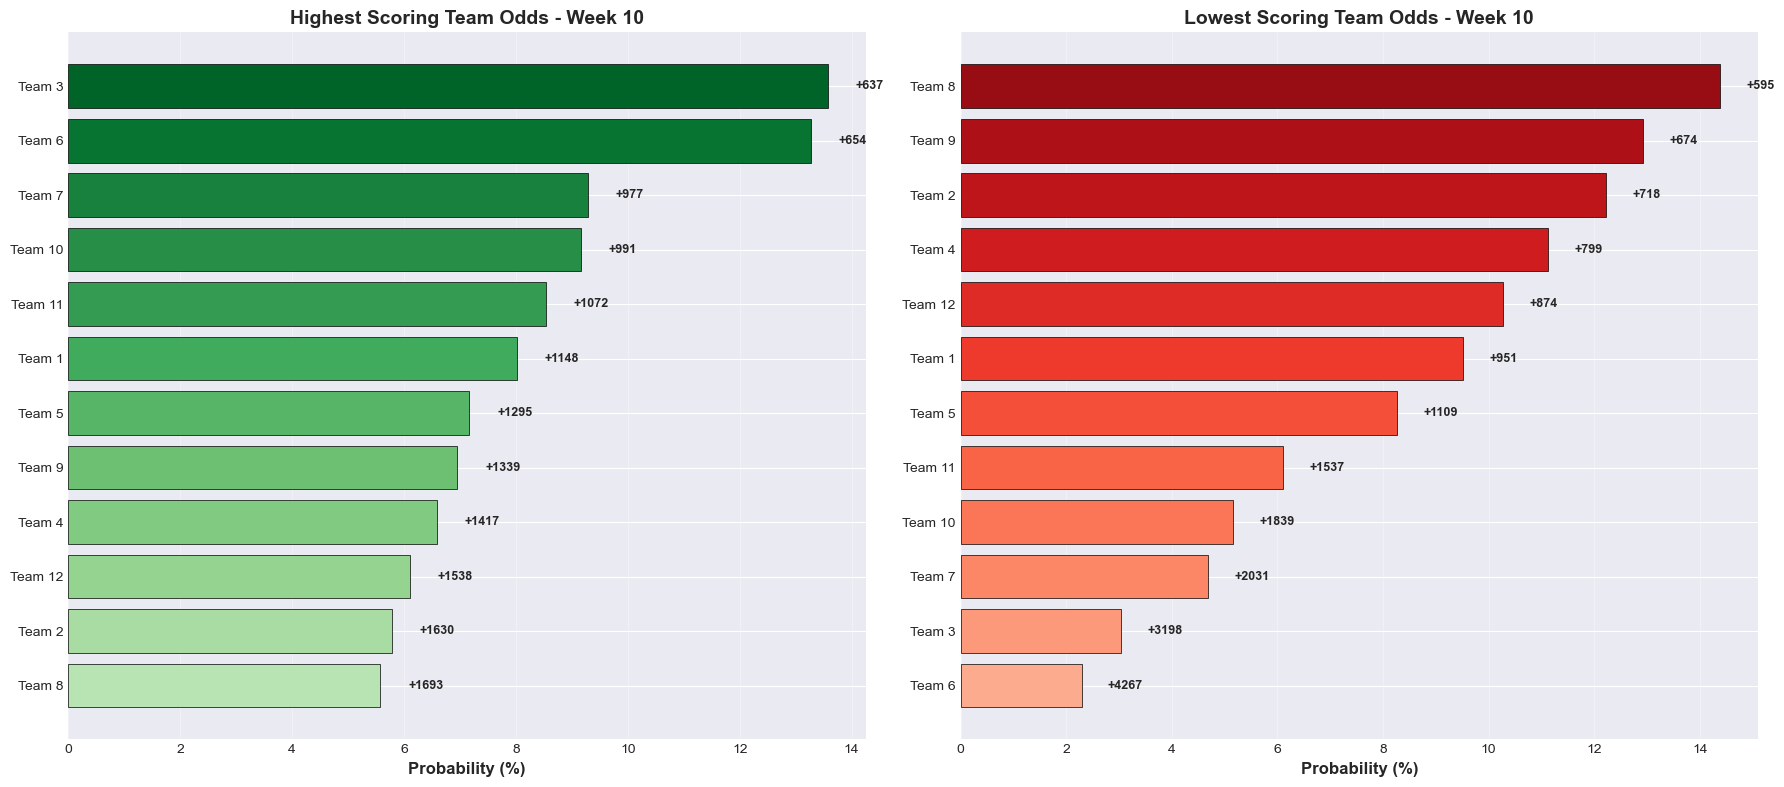

✓ Saved: betting_odds_high_low_week_10.png


In [24]:
# Create visualization for highest/lowest scorer odds
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Highest scorer
high_data = df_highest_scorer.sort_values('probability', ascending=True)
y_pos = np.arange(len(high_data))
colors_high = plt.cm.Greens(np.linspace(0.3, 0.9, len(high_data)))

ax1.barh(y_pos, high_data['probability']*100, color=colors_high, edgecolor='black', linewidth=0.5)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(high_data['team_name'])
ax1.set_xlabel('Probability (%)', fontsize=12, fontweight='bold')
ax1.set_title(f'Highest Scoring Team Odds - Week {CURRENT_WEEK}', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Add odds labels
for i, (prob, odds) in enumerate(zip(high_data['probability'], high_data['odds'])):
    ax1.text(prob*100 + 0.5, i, f"{odds}", va='center', fontsize=9, fontweight='bold')

# Lowest scorer
low_data = df_lowest_scorer.sort_values('probability', ascending=True)
y_pos = np.arange(len(low_data))
colors_low = plt.cm.Reds(np.linspace(0.3, 0.9, len(low_data)))

ax2.barh(y_pos, low_data['probability']*100, color=colors_low, edgecolor='black', linewidth=0.5)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(low_data['team_name'])
ax2.set_xlabel('Probability (%)', fontsize=12, fontweight='bold')
ax2.set_title(f'Lowest Scoring Team Odds - Week {CURRENT_WEEK}', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Add odds labels
for i, (prob, odds) in enumerate(zip(low_data['probability'], low_data['odds'])):
    ax2.text(prob*100 + 0.5, i, f"{odds}", va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(f'../data/images/betting_odds_high_low_week_{CURRENT_WEEK}.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: betting_odds_high_low_week_{CURRENT_WEEK}.png")


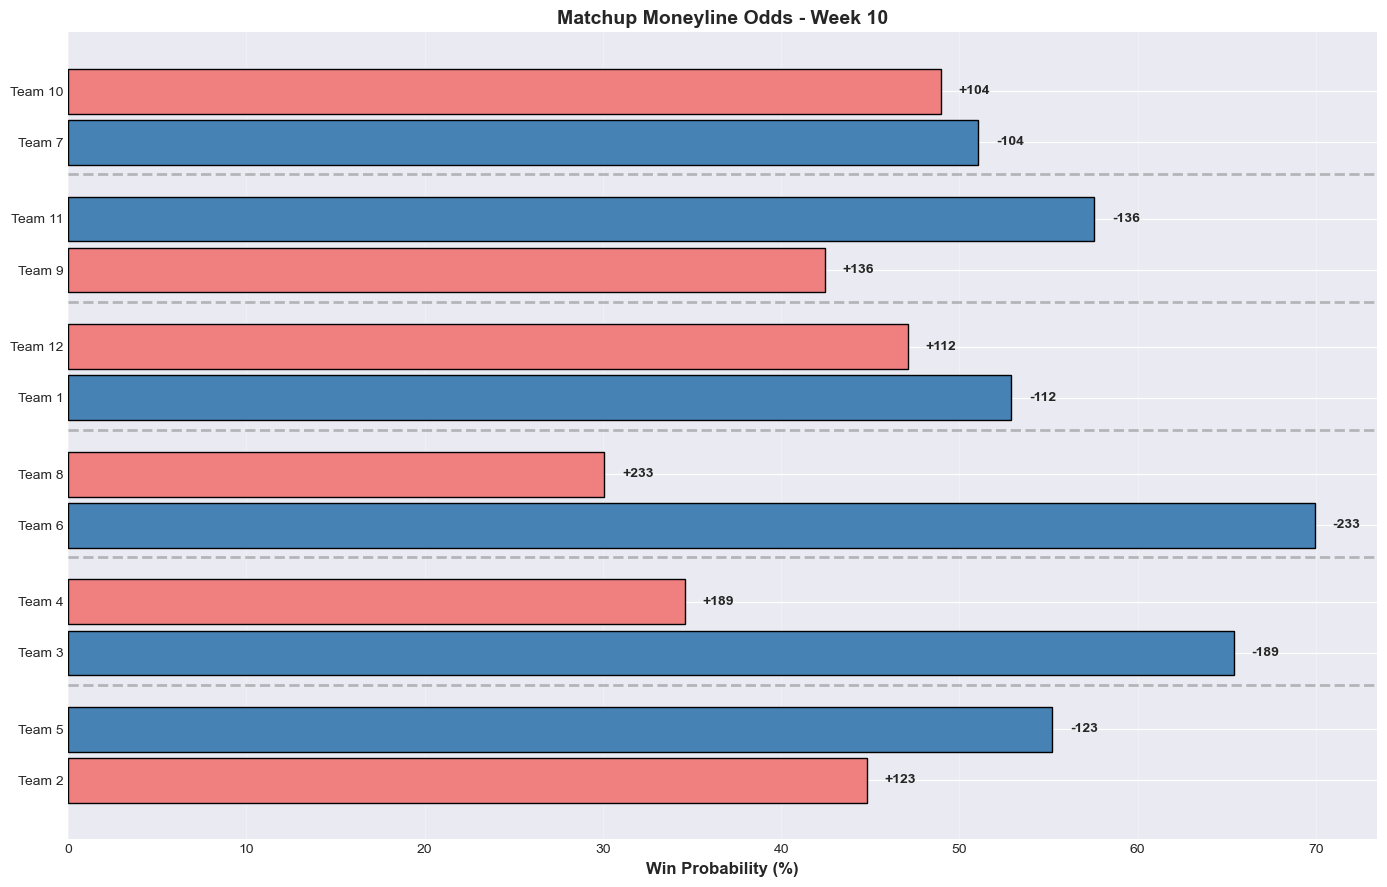

✓ Saved: betting_odds_moneyline_week_10.png


In [25]:
# Create matchup moneyline visualization
if len(df_matchup_ml) > 0:
    fig, ax = plt.subplots(figsize=(14, len(df_matchup_ml) * 1.5))
    
    y_pos = []
    labels = []
    probabilities = []
    colors = []
    odds_labels = []
    
    for idx, row in df_matchup_ml.iterrows():
        # Team 1
        y_pos.append(idx * 2)
        labels.append(f"{row['team1_name']}")
        probabilities.append(row['team1_win_prob'] * 100)
        colors.append('steelblue' if row['team1_win_prob'] > 0.5 else 'lightcoral')
        odds_labels.append(row['team1_ml'])
        
        # Team 2
        y_pos.append(idx * 2 + 0.8)
        labels.append(f"{row['team2_name']}")
        probabilities.append(row['team2_win_prob'] * 100)
        colors.append('steelblue' if row['team2_win_prob'] > 0.5 else 'lightcoral')
        odds_labels.append(row['team2_ml'])
    
    ax.barh(y_pos, probabilities, color=colors, edgecolor='black', linewidth=1, height=0.7)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Win Probability (%)', fontsize=12, fontweight='bold')
    ax.set_title(f'Matchup Moneyline Odds - Week {CURRENT_WEEK}', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Add odds labels
    for y, prob, odds in zip(y_pos, probabilities, odds_labels):
        ax.text(prob + 1, y, f"{odds}", va='center', fontsize=10, fontweight='bold')
    
    # Add matchup separators
    for i in range(1, len(df_matchup_ml)):
        ax.axhline(y=i*2 - 0.5, color='gray', linestyle='--', alpha=0.5, linewidth=2)
    
    plt.tight_layout()
    plt.savefig(f'../data/images/betting_odds_moneyline_week_{CURRENT_WEEK}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Saved: betting_odds_moneyline_week_{CURRENT_WEEK}.png")
else:
    print("⚠ No matchups to visualize")


## 📋 Updated Final Summary


In [26]:
print("="*100)
print("MONTE CARLO SIMULATION & BETTING ODDS - FINAL REPORT")
print("="*100)
print()
print(f"Week: {CURRENT_WEEK}")
print(f"Simulations per Team: {N_SIMULATIONS:,}")
print(f"Random Seed: {SEED}")
print(f"Run ID: {run_id}")
print(f"Distribution: Lognormal")
print(f"Odds Format: American (No Vig)")
print()

print("Betting Markets Generated:")
print("-" * 100)
print(f"  1. Team Over/Under ({len(df_team_ou)} teams)")
print(f"  2. Matchup Total O/U ({len(df_matchup_ou)} matchups)")
print(f"  3. Matchup Moneyline ({len(df_matchup_ml)} matchups)")
print(f"  4. Highest Scorer Props ({len(df_highest_scorer)} teams)")
print(f"  5. Lowest Scorer Props ({len(df_lowest_scorer)} teams)")
print()

print("Top Favorites (Highest Scorer):")
print("-" * 100)
for rank, team in enumerate(df_highest_scorer.head(3).itertuples(), 1):
    print(f"  {rank}. {team.team_name:25} {team.odds:>8} ({team.probability*100:5.2f}%)")
print()

print("Top Underdogs (Lowest Scorer):")
print("-" * 100)
for rank, team in enumerate(df_lowest_scorer.head(3).itertuples(), 1):
    print(f"  {rank}. {team.team_name:25} {team.odds:>8} ({team.probability*100:5.2f}%)")
print()

print("Database Storage:")
print("-" * 100)
print("  montecarlo.db:")
print("    • simulation_runs (metadata)")
print(f"    • monte_carlo_simulations ({len(df_simulations):,} rows)")
print()
print("  odds.db:")
print("    • betting_odds_team_ou")
print("    • betting_odds_matchup_ou")
print("    • betting_odds_matchup_ml")
print("    • betting_odds_highest_scorer")
print("    • betting_odds_lowest_scorer")
print()

print("CSV Files Generated:")
print("-" * 100)
print("  Simulation Data:")
print(f"    • monte_carlo_simulations_week_{CURRENT_WEEK}.csv")
print()
print("  Betting Odds CSV:")
print(f"    • betting_odds_team_ou_week_{CURRENT_WEEK}.csv")
print(f"    • betting_odds_matchup_ou_week_{CURRENT_WEEK}.csv")
print(f"    • betting_odds_matchup_ml_week_{CURRENT_WEEK}.csv")
print(f"    • betting_odds_highest_scorer_week_{CURRENT_WEEK}.csv")
print(f"    • betting_odds_lowest_scorer_week_{CURRENT_WEEK}.csv")
print()

print("Visualizations:")
print("-" * 100)
print(f"  • simulation_distributions_week_{CURRENT_WEEK}.png")
print(f"  • simulation_boxplot_week_{CURRENT_WEEK}.png")
print(f"  • simulation_violin_week_{CURRENT_WEEK}.png")
print(f"  • win_probability_heatmap_week_{CURRENT_WEEK}.png")
print(f"  • percentile_ranges_week_{CURRENT_WEEK}.png")
print(f"  • cdf_plot_week_{CURRENT_WEEK}.png")
print(f"  • betting_odds_high_low_week_{CURRENT_WEEK}.png")
print(f"  • betting_odds_moneyline_week_{CURRENT_WEEK}.png")
print()
print("="*100)
print("✓ Complete Analysis with Betting Odds!")
print("✓ Simulations stored in montecarlo.db")
print("✓ Betting odds stored in odds.db")
print("="*100)


MONTE CARLO SIMULATION & BETTING ODDS - FINAL REPORT

Week: 10
Simulations per Team: 50,000
Random Seed: 1738
Run ID: seed_1738_20251106_212816
Distribution: Lognormal
Odds Format: American (No Vig)

Betting Markets Generated:
----------------------------------------------------------------------------------------------------
  1. Team Over/Under (12 teams)
  2. Matchup Total O/U (6 matchups)
  3. Matchup Moneyline (6 matchups)
  4. Highest Scorer Props (12 teams)
  5. Lowest Scorer Props (12 teams)

Top Favorites (Highest Scorer):
----------------------------------------------------------------------------------------------------
  1. Team 3                        +637 (13.57%)
  2. Team 6                        +654 (13.27%)
  3. Team 7                        +977 ( 9.28%)

Top Underdogs (Lowest Scorer):
----------------------------------------------------------------------------------------------------
  1. Team 8                        +595 (14.38%)
  2. Team 9                     

## 💾 Database Query Examples

How to retrieve simulation and betting odds data from the database


In [27]:
# Example queries to retrieve data from the databases

print("="*100)
print("DATABASE QUERY EXAMPLES")
print("="*100)
print()

# 1. Get all simulation runs from montecarlo.db
print("1. All Simulation Runs (from montecarlo.db):")
print("-" * 100)
conn_mc = sqlite3.connect(DB_MONTECARLO_PATH)
df_runs = pd.read_sql_query("""
    SELECT run_id, week, seed, n_simulations, distribution_type, n_teams, 
           created_at
    FROM simulation_runs
    ORDER BY created_at DESC
    LIMIT 5
""", conn_mc)
print(df_runs.to_string(index=False))
conn_mc.close()
print()

# 2. Get simulations for specific run from montecarlo.db
print(f"2. Simulation Results for Current Run (from montecarlo.db):")
print("-" * 100)
conn_mc = sqlite3.connect(DB_MONTECARLO_PATH)
df_sims_query = pd.read_sql_query(f"""
    SELECT team_id, team_name, 
           COUNT(*) as n_sims,
           AVG(total_points) as avg_points,
           MIN(total_points) as min_points,
           MAX(total_points) as max_points
    FROM monte_carlo_simulations
    WHERE run_id = '{run_id}'
    GROUP BY team_id, team_name
    ORDER BY avg_points DESC
""", conn_mc)
print(df_sims_query.to_string(index=False))
conn_mc.close()
print()

# 3. Get moneyline odds for current run from odds.db
print(f"3. Moneyline Odds for Current Run (from odds.db):")
print("-" * 100)
conn_odds = sqlite3.connect(DB_ODDS_PATH)
df_ml_query = pd.read_sql_query(f"""
    SELECT matchup, 
           team1_name, team1_ml, 
           team2_name, team2_ml
    FROM betting_odds_matchup_ml
    WHERE run_id = '{run_id}'
""", conn_odds)
if len(df_ml_query) > 0:
    print(df_ml_query.to_string(index=False))
else:
    print("No matchup data found")
conn_odds.close()
print()

# 4. Get highest scorer odds from odds.db
print(f"4. Highest Scorer Odds (Top 5) (from odds.db):")
print("-" * 100)
conn_odds = sqlite3.connect(DB_ODDS_PATH)
df_high_query = pd.read_sql_query(f"""
    SELECT team_name, owner, odds, 
           ROUND(probability * 100, 2) as prob_pct,
           count
    FROM betting_odds_highest_scorer
    WHERE run_id = '{run_id}'
    ORDER BY probability DESC
    LIMIT 5
""", conn_odds)
print(df_high_query.to_string(index=False))
conn_odds.close()
print()

print("="*100)
print("Query Templates:")
print("="*100)
print()
print("Get all simulations for a specific team and week (montecarlo.db):")
print("  SELECT * FROM monte_carlo_simulations")
print("  WHERE run_id = 'YOUR_RUN_ID' AND team_id = YOUR_TEAM_ID")
print()
print("Get all betting odds for a specific week (odds.db):")
print("  SELECT * FROM betting_odds_team_ou WHERE week = YOUR_WEEK")
print()
print("Compare multiple simulation runs (montecarlo.db):")
print("  SELECT sr.*, ")
print("    (SELECT AVG(total_points) FROM monte_carlo_simulations ")
print("     WHERE run_id = sr.run_id) as avg_total_points")
print("  FROM simulation_runs sr")
print()
print("Join simulation and betting data:")
print("  -- First query montecarlo.db for simulations")
print("  -- Then query odds.db for betting odds")
print("  -- Join in pandas using run_id and week")
print()
print("="*100)


DATABASE QUERY EXAMPLES

1. All Simulation Runs (from montecarlo.db):
----------------------------------------------------------------------------------------------------
                   run_id  week  seed  n_simulations distribution_type  n_teams          created_at
seed_1738_20251106_212816    10  1738          50000         lognormal       12 2025-11-07 03:28:19

2. Simulation Results for Current Run (from montecarlo.db):
----------------------------------------------------------------------------------------------------
 team_id team_name  n_sims  avg_points  min_points  max_points
       6    Team 6   50000  125.636855   57.348760  337.916939
       3    Team 3   50000  125.275666   53.921468  718.808647
       7    Team 7   50000  119.129448   48.849750  368.287139
      10   Team 10   50000  118.401376   47.858247  327.217510
      11   Team 11   50000  116.750655   50.073779  331.259765
       5    Team 5   50000  113.795506   46.350430  386.940783
       1    Team 1   50000

## 🧹 Database Cleanup

Remove old simulation and betting tables from projections.db (now stored in montecarlo.db and odds.db)


In [28]:
# Clean up old tables from projections.db
print("="*100)
print("DATABASE CLEANUP - Removing old tables from projections.db")
print("="*100)
print()

conn_proj = sqlite3.connect(DB_PROJ_PATH)
cursor = conn_proj.cursor()

# List of tables to remove
tables_to_remove = [
    'monte_carlo_simulations',
    'simulation_runs',
    'betting_odds_team_ou',
    'betting_odds_matchup_ou',
    'betting_odds_matchup_ml',
    'betting_odds_highest_scorer',
    'betting_odds_lowest_scorer'
]

print("Checking for tables to remove...")
print()

for table_name in tables_to_remove:
    # Check if table exists
    cursor.execute("""
        SELECT name FROM sqlite_master 
        WHERE type='table' AND name=?
    """, (table_name,))
    
    result = cursor.fetchone()
    
    if result:
        # Get row count before dropping
        cursor.execute(f"SELECT COUNT(*) FROM {table_name}")
        row_count = cursor.fetchone()[0]
        
        # Drop the table
        cursor.execute(f"DROP TABLE IF EXISTS {table_name}")
        
        print(f"✓ Dropped table: {table_name} ({row_count:,} rows)")
    else:
        print(f"  Table not found: {table_name} (already removed or never existed)")

# Commit changes
conn_proj.commit()

# Verify tables are removed
cursor.execute("""
    SELECT name FROM sqlite_master 
    WHERE type='table' AND name IN (?, ?, ?, ?, ?, ?, ?)
""", tuple(tables_to_remove))

remaining_tables = cursor.fetchall()

print()
if remaining_tables:
    print("⚠ Warning: Some tables still exist:")
    for table in remaining_tables:
        print(f"  - {table[0]}")
else:
    print("✓ All simulation and betting tables successfully removed from projections.db")

# Show remaining tables in projections.db
cursor.execute("""
    SELECT name FROM sqlite_master 
    WHERE type='table'
    ORDER BY name
""")

remaining = cursor.fetchall()
print()
print("Remaining tables in projections.db:")
if remaining:
    for table in remaining:
        cursor.execute(f"SELECT COUNT(*) FROM {table[0]}")
        count = cursor.fetchone()[0]
        print(f"  • {table[0]} ({count:,} rows)")
else:
    print("  (No tables remain)")

# Run VACUUM to reclaim space
print()
print("Running VACUUM to reclaim disk space...")
cursor.execute("VACUUM")
print("✓ Database optimized")

conn_proj.close()

print()
print("="*100)
print("CLEANUP COMPLETE")
print("="*100)
print()
print("Summary:")
print(f"  • Simulation data → montecarlo.db")
print(f"  • Betting odds data → odds.db")
print(f"  • projections.db → cleaned up (simulation/betting tables removed)")
print()
print("="*100)


DATABASE CLEANUP - Removing old tables from projections.db

Checking for tables to remove...

✓ Dropped table: monte_carlo_simulations (3,600,000 rows)
✓ Dropped table: simulation_runs (6 rows)
✓ Dropped table: betting_odds_team_ou (24 rows)
✓ Dropped table: betting_odds_matchup_ou (12 rows)
✓ Dropped table: betting_odds_matchup_ml (12 rows)
✓ Dropped table: betting_odds_highest_scorer (24 rows)
✓ Dropped table: betting_odds_lowest_scorer (24 rows)

✓ All simulation and betting tables successfully removed from projections.db

Remaining tables in projections.db:
  • player_week_stats (537 rows)
  • projections (1,625 rows)
  • projections_with_sleeper (1,625 rows)
  • sqlite_sequence (2 rows)

Running VACUUM to reclaim disk space...
✓ Database optimized

CLEANUP COMPLETE

Summary:
  • Simulation data → montecarlo.db
  • Betting odds data → odds.db
  • projections.db → cleaned up (simulation/betting tables removed)

